In [58]:
import os
import torch
from torch import optim
import torch.nn as nn
from scipy.io import wavfile
import numpy as np
from torch import fft
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [59]:
### Define our data loader

class FourierDataset(Dataset):

    def __init__(self, root_dir, sample_length = 44101, add_noise = False):
        exts = os.listdir(root_dir)
        
        self.length = len(exts)
        self.add_noise = add_noise
        self.data = np.zeros([len(exts) , sample_length])
        self.labels = list(range(len(self.data)))

        for i,ex in enumerate(exts):
            _ , x = wavfile.read(f'{root_dir}/{ex}')
            self.data[i,:] = x

        self.data = self.data/32768
        self.data = torch.tensor(self.data, dtype = torch.float32)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        x = self.data[idx,:].clone()
        y = self.labels[idx]
        
        if self.add_noise:
            x = x + 0.05*torch.randn(x.shape)
        
        return x,y


In [60]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_dimension = 44101
clipped_data_dimension = data_dimension // 2
output_dimension = 1000 * 2 # The first 1000 frequencies in real and complex components
epochs = 5000

# Define dataset and loader
dataset = FourierDataset('chord_dataset', add_noise = True)
loader = DataLoader(dataset,batch_size = 128)

# Define model and optimizer
model = nn.Linear(clipped_data_dimension,output_dimension, bias = False).to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5, patience = 250, verbose = True)




In [61]:
# Train the model

model.train()
for epoch in range(epochs):
    for i, (data, _) in enumerate(loader):
        # Compute the Fourier transform of the data. This is our target
        data = data[:, 0:clipped_data_dimension]
        target = fft.rfft(data)[:,0:1000]
        r = torch.real(target)
        i = torch.imag(target)
        target = torch.hstack([r,i])

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
    scheduler.step(loss)
    if epoch % 100 == 0:
        print(f'Epoch {epoch} ---- Loss {loss.item()}')



Epoch 0 ---- Loss 17168.65625
Epoch 100 ---- Loss 224.3651885986328
Epoch 200 ---- Loss 55.41950988769531
Epoch 300 ---- Loss 54.723487854003906
Epoch 400 ---- Loss 55.60187530517578
Epoch   480: reducing learning rate of group 0 to 5.0000e-03.
Epoch 500 ---- Loss 41.012237548828125
Epoch 600 ---- Loss 40.622066497802734
Epoch 700 ---- Loss 42.56623840332031
Epoch   775: reducing learning rate of group 0 to 2.5000e-03.
Epoch 800 ---- Loss 34.089149475097656
Epoch 900 ---- Loss 34.6707763671875
Epoch 1000 ---- Loss 34.59676742553711
Epoch 1100 ---- Loss 34.49490737915039
Epoch  1163: reducing learning rate of group 0 to 1.2500e-03.
Epoch 1200 ---- Loss 30.798372268676758
Epoch 1300 ---- Loss 30.679197311401367
Epoch 1400 ---- Loss 30.76699447631836
Epoch 1500 ---- Loss 30.741405487060547
Epoch  1545: reducing learning rate of group 0 to 6.2500e-04.
Epoch 1600 ---- Loss 29.157560348510742
Epoch 1700 ---- Loss 29.216136932373047
Epoch 1800 ---- Loss 28.719961166381836
Epoch  1848: reducin

(2000, 22050)


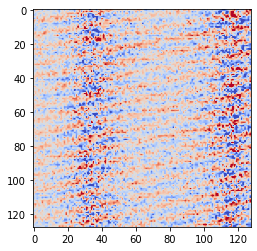

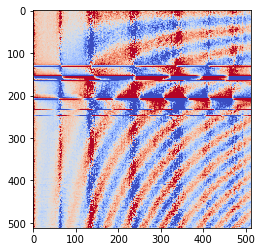

In [62]:
v_bound = 0.05
weights = model.weight[:,0:].detach().cpu().numpy()

print(weights.shape)
square_size = 128
point = (500 - 50,22050 // 8 - 100)
plt.imshow(weights[point[0]:point[0] + square_size,point[1]:point[1] + square_size], cmap='coolwarm',vmin = -v_bound, vmax = v_bound)
plt.show()
plt.imshow(weights[0:512,0:512], cmap='coolwarm',vmin = -v_bound, vmax = v_bound)
plt.show()



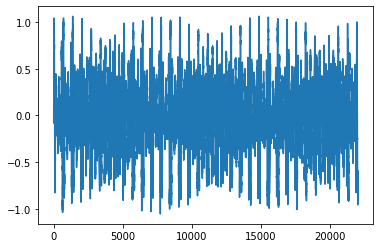

In [63]:

# clipped_data_dimension = 20000
sample,_ = dataset.__getitem__(0)
sample = sample.clone()
sample += 0.0*torch.randn(sample.shape)
plt.plot(sample[0:clipped_data_dimension])
plt.show()





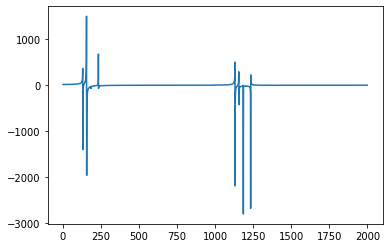

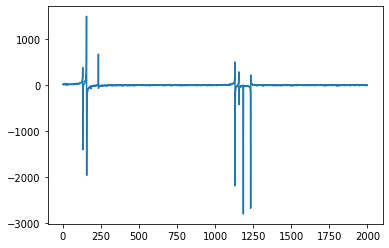

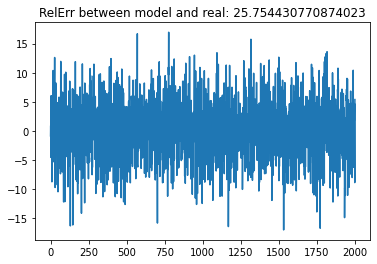

In [64]:

with torch.no_grad():
    model.to('cpu')
    sample,_ = dataset.__getitem__(5)
    sample = sample[0:clipped_data_dimension]
    out = model(sample)

    target = fft.rfft(sample)[0:1000]
    r = torch.real(target)
    i = torch.imag(target)
    target = torch.hstack([r,i])
    plt.plot(out)
    plt.show()
    plt.plot(target)
    plt.show()
    
     
    plt.plot((out - target))
    plt.title(f'RelErr between model and real: {loss_function(out,target)}')
    plt.show()

    


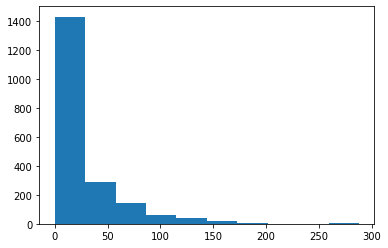

Epoch 0 ---- Loss 32.15602111816406
Epoch 100 ---- Loss 2.0789589881896973
Epoch 200 ---- Loss 0.031733687967061996
Epoch 300 ---- Loss 0.00016669418255332857
Epoch 400 ---- Loss 3.041296849914943e-07
Epoch 500 ---- Loss 3.0114008509052326e-10
Epoch 600 ---- Loss 5.215059287189128e-12
Epoch 700 ---- Loss 4.669451023758819e-12
Epoch 800 ---- Loss 4.4434898469059014e-12
Epoch 900 ---- Loss 3.878513829547181e-12


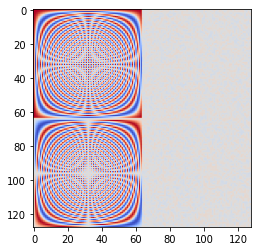

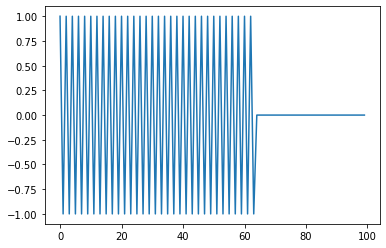

In [65]:

serr = (torch.abs(out - target)**2).detach().cpu().numpy()
plt.hist(serr)
plt.show()



device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 1000

# Define dataset and loader
batch = 100
N = 64

# Define model and optimizer
model = nn.Linear(N*2,N*2, bias = False).to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.01)



model.train()
for epoch in range(epochs):       
    sig = torch.randn(batch, N) + 0.0000000001*1j*np.random.randn(batch, N)
    sig = torch.randn(batch, N) + 0j
    F = fft.fft(sig, dim=-1)

    # # First half of inputs/outputs is real part, second half is imaginary part
    X = torch.hstack([torch.real(sig), torch.imag(sig)])
    Y = torch.hstack([F.real, F.imag])

    X, Y = X.float().to(device), Y.float().to(device)

    optimizer.zero_grad()
    output = model(X)
    loss = loss_function(output, Y)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch} ---- Loss {loss.item()}')



weights = model.weight[:,0:].detach().cpu().numpy()
plt.imshow(weights, cmap='coolwarm')
plt.show()
plt.plot(weights[0:100,32])
plt.show()